# Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns

# Visualisations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Cell output display -- all
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# Ignore exceptions
import expectexception

# Activate auto-conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load extension for %%R cells
%load_ext rpy2.ipython

In [2]:
%%R

# load the R library
library(ggplot2)
library(ggalt)
theme_set(theme_light())

library(scales)
library(dplyr)

R[write to console]: Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Cleaning

In [3]:
train_tr = pd.read_csv('./data/train_transaction.csv')
train_id = pd.read_csv('./data/train_identity.csv')
test_tr = pd.read_csv('./data/test_transaction.csv')
test_id = pd.read_csv('./data/test_identity.csv')

In [5]:
tr_raw = pd.merge(train_tr, train_id, how='left')
id_raw = pd.merge(test_tr, test_id, how='left')

In [ ]:
# train_tr_copy = train_tr.drop('isFraud', axis=1)
# tr_raw = pd.concat([train_tr_copy, test_tr], sort=False)
# id_raw = pd.concat([train_id, test_id], sort=False)

In [ ]:
train_tr.shape  ## (590540, 394)
train_id.shape  ## (144233, 41)

In [39]:
### Categorical columns as noted by Vesta
def paste0(string, start, end):
    return list(map(lambda x: ''.join(x), zip([string]*(end - start + 1), map(str, range(start, end + 1)))))

cards = paste0('card', 1, 6)
Ms = paste0('M', 1, 9)
ids = paste0('id_', 12, 38)

cat_tr = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + cards + Ms
cat_id = ['DeviceType', 'DeviceInfo'] + ids
cats = cat_tr + cat_id

# Fraud Aggregations

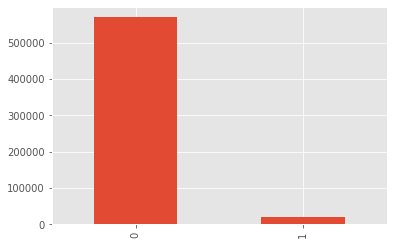

In [37]:
tr_raw['isFraud'].value_counts().plot.bar()

In [ ]:
### function to check for outlying fraud values in columns
### can be modified to identify individual values, such as 'protonmail.com'
### returns a list of columns to EDA
def outlying_fraud(in_df, cols, threshold=0.85):
    record = []
    for col in cols:
        uniques = in_df[col].unique()
        
        for uni in uniques:
            all = in_df[in_df[col] == uni]['isFraud']
            percent_fraud = all.sum()/all.shape[0]
            
            if percent_fraud > threshold:
#                 print('{} has {} fraud for value {}'.format(col, percent_fraud, uni))
                record.append(col)
                print(col)
                break        
    return record

### function to graph outlying fraud values in identified columns
def graph_freq(feature, count):
    grouped = tr_raw.groupby(feature)['isFraud'].agg({'fraud':'sum','total':'count'})
    freq = grouped.fraud/grouped.total
    freq = freq.nlargest(count)
    return freq.plot.bar()

### function to count high-outlying values in pre-identified columns
def outlying_matrix(in_df, cols):
    matrix = {}
    for col in cols:
        grouped = in_df.groupby(col)['isFraud'].agg({'fraud':'sum','total':'count'})
        freq = grouped.fraud/grouped.total
        matrix[col] = freq[freq > 0.9].count()
    return matrix

### number of unique values in select columns
def nunique_sel(in_df, cols):
    matrix = {}
    for col in cols:
        matrix[col] = in_df[col].nunique()        
    return matrix

### divide two dictionaries via key
def divide(num, denom):
    return {key: num[key] / denom[key] for key in denom if key in num}

In [188]:
### general multivariates
raw_corr = tr_raw.corr()
tr_raw.describe()

In [192]:
raw_corr.iloc[1:2, :]

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
isFraud,0.014166,1.0,0.013103,0.01132,-0.01364,0.003388,0.154151,-0.03358,0.005596,-0.030387,0.021522,-0.019054,0.03057,0.037229,-0.006833,0.030382,-0.030754,0.020909,0.02816,0.032139,-0.031703,0.028396,0.027484,0.031905,-0.011146,0.007921,-0.067193,-0.083583,-0.046271,-0.067216,-0.064638,-0.057236,-0.127199,-0.142636,-0.044253,-0.072002,-0.045094,-0.028864,-0.05943,-0.008663,-0.077519,0.001045,0.019872,0.049257,0.012611,0.036904,0.010552,0.023492,0.016041,0.037915,-0.074658,-0.07195,-0.052406,-0.045706,0.002145,0.177963,0.174318,0.182673,0.18255,0.030904,0.040341,0.165985,0.158814,0.149408,0.123824,0.003826,0.015929,-0.004979,-0.004895,-0.107852,-0.103088,0.163166,0.160197,0.183486,0.180301,-0.077116,-0.069875,0.176947,0.199005,0.203097,0.212442,0.004154,0.189428,0.198274,0.260376,0.281832,0.125991,0.164114,-0.115786,-0.11092,0.179953,0.223191,0.239469,-0.0474,-0.037025,0.050114,0.061356,0.168887,0.173065,0.151062,0.150952,0.049412,0.072399,0.153353,0.150371,0.002701,0.037631,0.076194,-0.004048,-0.104521,-0.1009,0.15684,0.160951,0.17387,0.185915,-0.052171,-0.046419,0.158381,0.150425,0.194141,0.180299,0.182377,0.051115,0.069155,0.16911,0.16884,0.251828,0.251737,0.000554,-0.005188,-0.110168,-0.105453,0.180513,0.180983,0.188407,-0.00412,-0.005484,-0.004491,0.027318,-0.013179,0.011286,-0.004712,-0.004848,-0.005121,0.003485,-0.003229,-0.002091,0.002554,0.096794,0.060994,0.08163,0.12161,0.105212,0.115976,0.096086,0.057108,0.080644,0.049439,0.040601,0.048135,0.019678,0.01233,0.018712,0.138222,0.076721,0.111999,-0.003546,-0.002629,-0.00193,0.012731,0.003076,0.024975,-0.004263,-0.003165,-0.003512,-0.000276,-0.000042,-0.000115,0.042658,0.147594,0.196938,0.085628,0.080411,-0.029767,-0.05197,-0.061964,0.198584,0.242894,0.228891,0.273282,-0.063965,-0.060868,-0.059154,0.183114,0.206958,0.234199,0.275952,0.234866,0.278066,-0.06266,-0.062338,0.039806,0.053302,0.046532,-0.027445,-0.051399,-0.029436,-0.012854,-0.016021,0.068103,0.249794,0.216508,-0.013237,-0.021349,0.016204,-0.002222,0.164343,-0.013715,-0.016543,-0.015904,-0.009339,0.028337,-0.010108,-0.0006

In [187]:
all_outliers = outlying_fraud(tr_raw, tr_raw.columns)

In [204]:
outliers = outlying_matrix(tr_raw, all_outliers)
nuniques = nunique_sel(tr_raw, all_outliers)
divide(outliers, nuniques)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




{'TransactionID': 0.03499000914417313,
 'isFraud': 0.5,
 'TransactionDT': 0.03424092481193828,
 'TransactionAmt': 0.016553439862214143,
 'card1': 0.015125802405371504,
 'card3': 0.07017543859649122,
 'card5': 0.008403361344537815,
 'addr2': 0.08108108108108109,
 'dist1': 0.006035458317615994,
 'dist2': 0.01656196459166191,
 'R_emaildomain': 0.016666666666666666,
 'C1': 0.07905853952926976,
 'C2': 0.11595394736842106,
 'C4': 0.07142857142857142,
 'C6': 0.043674698795180725,
 'C7': 0.0843155031731641,
 'C8': 0.11412609736632083,
 'C10': 0.056051990251827784,
 'C11': 0.051490514905149054,
 'C12': 0.13344453711426188,
 'C13': 0.01878522229179712,
 'C14': 0.02075812274368231,
 'D8': 0.012142799320003238,
 'D12': 0.0015748031496062992,
 'D14': 0.0024937655860349127,
 'V17': 0.4375,
 'V18': 0.375,
 'V21': 0.16666666666666666,
 'V23': 0.2857142857142857,
 'V24': 0.07142857142857142,
 'V25': 0.14285714285714285,
 'V33': 0.14285714285714285,
 'V37': 0.6363636363636364,
 'V38': 0.5454545454545454

In [205]:
outliers

### pick up outliers with high repeats/low percentages as criminals likely 
### see reason to track that variable en masse and, secondly, outliers with 
### high percentages in a reasonably sized pool of values

{'TransactionID': 20663,
 'isFraud': 1,
 'TransactionDT': 19632,
 'TransactionAmt': 346,
 'card1': 205,
 'card3': 8,
 'card5': 1,
 'addr2': 6,
 'dist1': 16,
 'dist2': 29,
 'R_emaildomain': 1,
 'C1': 131,
 'C2': 141,
 'C4': 90,
 'C6': 58,
 'C7': 93,
 'C8': 143,
 'C10': 69,
 'C11': 76,
 'C12': 160,
 'C13': 30,
 'C14': 23,
 'D8': 150,
 'D12': 1,
 'D14': 2,
 'V17': 7,
 'V18': 6,
 'V21': 1,
 'V23': 4,
 'V24': 1,
 'V25': 1,
 'V33': 1,
 'V37': 35,
 'V38': 30,
 'V40': 2,
 'V44': 42,
 'V45': 40,
 'V46': 2,
 'V47': 2,
 'V51': 2,
 'V52': 2,
 'V54': 1,
 'V67': 1,
 'V69': 1,
 'V70': 1,
 'V74': 1,
 'V76': 1,
 'V77': 11,
 'V78': 7,
 'V80': 4,
 'V81': 4,
 'V82': 0,
 'V86': 19,
 'V87': 19,
 'V92': 0,
 'V108': 3,
 'V109': 3,
 'V110': 3,
 'V111': 5,
 'V112': 5,
 'V113': 5,
 'V114': 2,
 'V115': 1,
 'V116': 2,
 'V120': 1,
 'V122': 1,
 'V123': 7,
 'V124': 3,
 'V125': 7,
 'V126': 993,
 'V127': 1305,
 'V128': 1156,
 'V129': 61,
 'V130': 156,
 'V131': 99,
 'V132': 916,
 'V133': 1138,
 'V134': 1051,
 'V135': 14

In [206]:
graph_freq('addr2', 10)
graph_freq('R_emaildomain', 10)
graph_freq('card1', 250)
graph_freq('card3', 10)
graph_freq('card5', 10)
graph_freq('DeviceInfo', 100)
graph_freq('id_13', 10)
graph_freq('id_14', 10)
graph_freq('id_17', 10)
graph_freq('id_19', 10)
graph_freq('id_20', 20)
graph_freq('id_21', 20)
graph_freq('id_22', 10)
graph_freq('id_24', 10)
graph_freq('id_25', 20)
graph_freq('id_26', 10)
graph_freq('id_31', 10)
graph_freq('id_33', 20)

# Time Conversions

In [ ]:
tr_raw['timedelta'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

# Null Patterns

In [376]:
from pandas.api.types import is_numeric_dtype

### find numeric columns
def numerics(in_df, dtype):
    df = in_df.copy()
    return [col for col in df.columns if is_numeric_dtype(df[col])]

def str_cols(in_df):
    df = in_df.copy()
    return [col for col in df.columns if is_string_dtype(df[col])]

### identify cols with null values
def nulls(in_df):
    df = in_df.copy()
    return df.loc[:, df.isnull().any()].columns
        
### plot null frequencies across columns
def nullplot(in_df):
    return (in_df.isnull().sum()/len(in_df)).plot(kind='bar', figsize=(30,8)).set(ylabel='frequency NA', xlabel='var')

### check for consistency of null groups
def null_groupby_check(in_df):
    rule_breaker = []
    ncount = np.sum(tr_raw.isnull())
    null_groups = list(ncount.groupby(ncount))
    for i in range(len(null_groups)):
        null_subset = null_groups[i][1]
        if in_df.loc[in_df[null_subset.index[0]].isnull()][null_subset.index].isnull().values.all() == 1:
            print('null_group {} did not break the rules.'.format(i))
        else:
            rule_breaker.append(null_subset)
    return rule_breaker

[Text(0, 0.5, 'frequency NA'), Text(0.5, 0, 'var')]

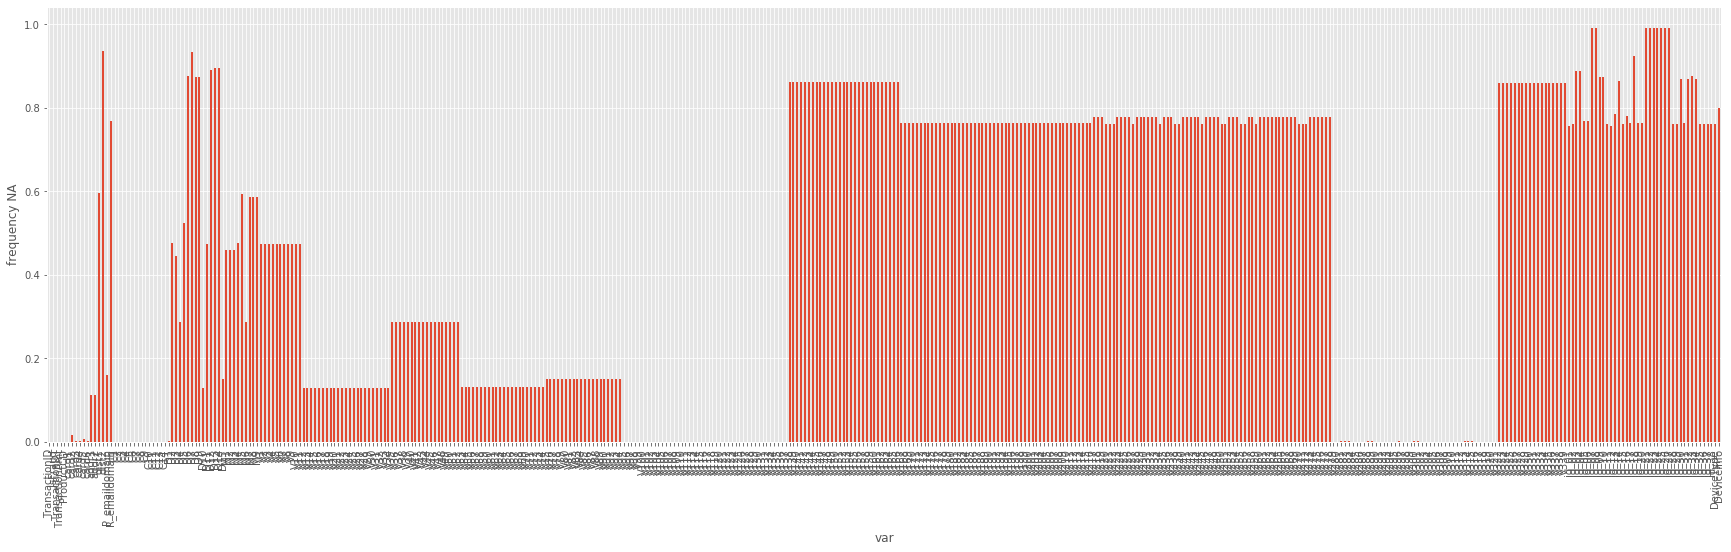

In [209]:
nullplot(tr_raw)

In [372]:
null_groupby_check(tr_raw)
### No rule breaks --- pattern holds.

null_group 0 did not break the rules.
null_group 1 did not break the rules.
null_group 2 did not break the rules.
null_group 3 did not break the rules.
null_group 4 did not break the rules.
null_group 5 did not break the rules.
null_group 6 did not break the rules.
null_group 7 did not break the rules.
null_group 8 did not break the rules.
null_group 9 did not break the rules.
null_group 10 did not break the rules.
null_group 11 did not break the rules.
null_group 12 did not break the rules.
null_group 13 did not break the rules.
null_group 14 did not break the rules.
null_group 15 did not break the rules.
null_group 16 did not break the rules.
null_group 17 did not break the rules.
null_group 18 did not break the rules.
null_group 19 did not break the rules.
null_group 20 did not break the rules.
null_group 21 did not break the rules.
null_group 22 did not break the rules.
null_group 23 did not break the rules.
null_group 24 did not break the rules.
null_group 25 did not break the rul

[]

# Refuse

In [ ]:
# # ## attempt to identify numeric categoricals
# def catnumerics(in_df):
#     numcol = numerics(in_df)
#     catnum = []
    
#     for col in numcol:
# #         if (in_df[col].nunique() > 100) and (in_df[col].nunique() < 180):
#             print('{} is a catnumeric with {} unique values'.format(col, in_df[col].nunique()))

# #             print('{} is a catnumeric with {} unique values of {}'.format(col, in_df[col].nunique(), sorted(in_df[col].unique())))
#             catnum.append(col)
            
#     print('{} columns'.format(len(catnum)))
#     return catnum

# def test_catnum(in_df):
#     catnum = catnumerics(in_df)
#     for col in catnum:
# #         count = in_df[col].value_counts().sort_index().to_frame().reset_index().plot.bar()
#         print(in_df[col].value_counts().sort_index())